# Import Packages

In [1]:
import pytz
from datetime import datetime
import matplotlib.pyplot as plt
from acnportal import acnsim
from acnportal import acndata
from acnportal import algorithms
import pandas as pd

# Import Dataset

In [2]:
df = pd.read_csv('2020-2-28df_session.csv')

# Convert time related columns to datetime objects.
df['evConnectionTime'] = df['evConnectionTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
df['sessionStopTime'] = df['sessionStopTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
df.sort_values(by=['evConnectionTime'])

,Unnamed: 0,WhDelivered,WhPerMile,chargeSessionId,doneChargingNotificationSent,driverId,driverIsExempt,evConnectionTime,milesNeeded,minutesAvailable,modifiedAt,sessionStartTime,sessionStopTime,siteId,spaceId,stationId,subSiteId,userStopped,wasOffline
3,3,8648,400,33_73_211_963_2020-02-28 15:03:38.480600,True,1065.0,False,2020-02-28 15:03:38,60,305,2020-02-28T18:02:05Z,2020-02-28T15:03:45Z,2020-02-28 18:02:05,33,B41-12,33-73-211-963,73,False,False
2,2,14014,400,33_73_211_967_2020-02-28 15:11:21.810719,True,2504.0,False,2020-02-28 15:11:22,50,100,2020-02-28T17:54:34Z,2020-02-28T15:11:52Z,2020-02-28 17:54:34,33,B41-14,33-73-211-967,73,False,False
4,4,6580,450,33_73_211_956_2020-02-28 15:16:35.111620,True,1028.0,False,2020-02-28 15:16:35,20,234,2020-02-28T18:03:12Z,2020-02-28T15:16:39Z,2020-02-28 18:03:13,33,B41-01,33-73-211-956,73,False,False
0,0,4648,300,33_73_211_958_2020-02-28 15:18:40.982084,True,1426.0,False,2020-02-28 15:18:41,20,161,2020-02-28T17:44:09Z,2020-02-28T15:18:50Z,2020-02-28 17:44:10,33,B41-15,33-73-211-958,73,False,False
21,15,43878,341,33_73_211_957_2020-02-28 15:21:13.980188,False,1655.0,False,2020-02-28 15:21:14,180,553,2020-02-29T00:30:18Z,2020-02-28T15:21:32Z,2020-02-29 00:30:18,33,B41-13,33-73-211-957,73,False,False
16,10,8127,333,33_73_211_955_2020-02-28 15:42:42.854153,True,929.0,False,2020-02-28 15:42:43,30,412,2020-02-28T23:24:26Z,2020-02-28T15:42:54Z,2020-02-28 23:24:26,33,B41-04,33-73-211-955,73,False,False
6,0,5681,400,33_73_211_968_2020-02-28 15:48:55.086807,True,1129.0,False,2020-02-28 15:48:55,20,166,2020-02-28T20:23:11Z,2020-02-28T15:49:22Z,2020-02-28 20:23:12,33,B41-10,33-73-211-968,73,False,False
10,4,12938,250,33_73_211_954_2020-02-28 15:56:13.765382,True,895.0,False,2020-02-28 15:56:14,60,77,2020-02-28T21:44:11Z,2020-02-28T15:56:20Z,2020-02-28 21:44:12,33,B41-07,33-73-211-954,73,False,False
9,3,4037,400,33_73_211_969_2020-02-28 16:16:45.395767,True,956.0,False,2020-02-28 16:16:45,20,60,2020-02-28T20:49:58Z,2020-02-28T16:17:06Z,2020-02-28 20:49:59,33,B41-05,33-73-211-969,73,False,False
1,1,4385,400,33_73_211_965_2020-02-28 16:21:21.291248,True,923.0,False,2020-02-28 16:21:21,60,292,2020-02-28T17:53:02Z,2020-02-28T16:21:42Z,2020-02-28 17:53:03,33,B41-16,33-73-211-965,73,False,False


# Experiment Parameters

In [3]:
# Timezone of the ACN we are using.
timezone = pytz.timezone('America/Los_Angeles')

# Start and End times of the simulation.
start = datetime(2020, 2, 28, 14)
end = datetime(2020, 2, 29)

# How long each time discrete time interval in the simulation should be.
period = 5  # minutes

# Voltage of the network.
voltage = 220  # volts

phase_angle = 30 # degrees

# Default maximum charging rate for each EV battery.
default_max_power = 32 * voltage / 1000 # kW

# Charging Network Setup

In [4]:
station_id_list = df['spaceId'].unique() # list of all unique spaceIDs in the dataset
cn = acnsim.network.ChargingNetwork()
for i in df.index:
    cur_EVSE = acnsim.models.evse.EVSE(df['spaceId'][i], max_rate=80, min_rate=0) 
    cn.register_evse(cur_EVSE,voltage,phase_angle)

# Events

In [5]:
# function for creating two events (plugin and unplug) for each charging session
def create_event(event_data):
    # Convert arrival and departure times to number of periods since simulation started.
    arrival = int((event_data['evConnectionTime'] - start).seconds/60/period)
    departure = int((event_data['sessionStopTime'] - start).seconds/60/period)
    
    # Requested energy in kWh
    requested_energy = event_data['milesNeeded']*event_data['WhPerMile']/1000
    
    space_id = event_data['spaceId']
    session_id = event_data['chargeSessionId']
    
    # assume that the battery is empty and the capacity is the requested energy
    default_capacity = requested_energy
    default_init_charge = 0
    battery = acnsim.models.battery.Battery(default_capacity, default_init_charge, default_max_power)
    
    # create EV object
    ev = acnsim.models.ev.EV(arrival, departure, requested_energy, space_id, session_id, battery, estimated_departure=None)
    
    #create plugin and unplug events using the EV object
    plugin_event = acnsim.events.PluginEvent(arrival,ev)
    unplug_event = acnsim.events.UnplugEvent(departure, space_id, session_id)
    return (plugin_event, unplug_event)

# loop over the dataset and create a queue of plugin and unplug event for each session
events = acnsim.events.EventQueue()
for index, row in df.iterrows(): 
    events.add_events(create_event(row))



# Scheduling Algorithm

In [6]:
algorithm = algorithms.UncontrolledCharging()
# Alternative algorithms: RoundRobin, earliest_deadline_first, first_come_first_served, 
# largest_remaining_processing_time, last_come_first_served, least_laxity_first

# Simulation

In [7]:
sim = acnsim.Simulator(cn, algorithm, events, start, period=period, verbose=False)
sim.run()

# Analysis

Proportion of requested energy delivered: 0.8491222813194492
Peak aggregate current: 384.0 A


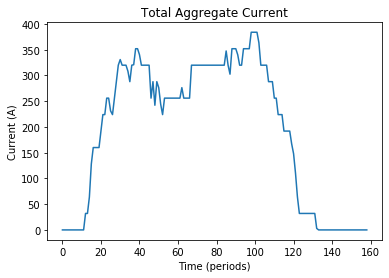

In [8]:
def analyze_simulation(sim):
    total_energy_prop = acnsim.proportion_of_energy_delivered(sim)
    print('Proportion of requested energy delivered: {0}'.format(total_energy_prop))
    print('Peak aggregate current: {0} A'.format(sim.peak))
    # Plotting aggregate current
    agg_current = acnsim.aggregate_current(sim)
    plt.plot(agg_current)
    plt.xlabel('Time (periods)')
    plt.ylabel('Current (A)')
    plt.title('Total Aggregate Current')
    plt.savefig('output.png')
    plt.show()
analyze_simulation(sim)

In [4]:
dir(algorithms)

['BaseAlgorithm',
 'RoundRobin',
 'SortedSchedulingAlgo',
 'UncontrolledCharging',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base_algorithm',
 'copy',
 'deque',
 'earliest_deadline_first',
 'first_come_first_served',
 'largest_remaining_processing_time',
 'last_come_first_served',
 'least_laxity_first',
 'np',
 'sorted_algorithms',
 'uncontrolled_charging']

In [8]:
import inspect

In [34]:
inspect.getdoc(algorithms.earliest_deadline_first)

'Sort EVs by departure time in increasing order.\n\nArgs:\n    evs (List[EV]): List of EVs to be sorted.\n    iface (Interface): Interface object. (not used in this case)\n\nReturns:\n    List[EV]: List of EVs sorted by departure time in increasing order.'

In [18]:
a = [1,2,3]

In [20]:
a[1:3]

[2, 3]

In [1]:
!jupyter nbconvert --to script Powerflex_demo.ipynb

[NbConvertApp] Converting notebook Powerflex_demo.ipynb to script
[NbConvertApp] Writing 3995 bytes to Powerflex_demo.py
